In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

pj = os.path.join

%matplotlib inline

In [2]:
TRAIN_DIR = "/home/matt/Data/Waveforms/"

In [86]:
conf = {}
conf["numh"] = 4

conf["num_epochs"] = 2000
conf["lr"] = 0.01

In [87]:
g_waves = None
g_num_waves = None
g_num_samps = None

In [88]:
def readDzirasa():
    global g_waves, g_num_waves, g_num_samps
    with open(pj(TRAIN_DIR, "DzirasaData.txt")) as fp:
        reader = csv.reader(fp, delimiter='\t')
        header = next(reader)
        g_num_waves = int( header[0] )
        g_num_samps = int( header[1] )
        waves = []
        for row in reader:
            waves.append( row[2:] )
    g_waves = np.copy(waves)
#    g_waves = np.array(waves, np.float)

readDzirasa()

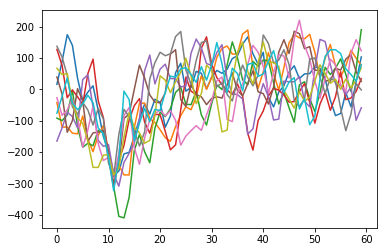

In [89]:
plt.figure()
for i in range(1000,1010):
    plt.plot(g_waves[i,:])

In [90]:
tf.reset_default_graph()

In [91]:
x = tf.placeholder(tf.float32, shape=(None, g_num_samps), name="x")

In [92]:
with tf.name_scope("encoder"):
    shape1 = [g_num_samps, conf["numh"]]
    W_enc = tf.Variable(tf.random_normal(shape1, stddev=0.5), name="W_enc")
    b_enc = tf.Variable(tf.random_normal([conf["numh"]], stddev=0.5), name="b_enc")
    y = tf.matmul(x, W_enc) + b_enc
    h = tf.nn.tanh(y)

In [93]:
with tf.name_scope("decoder"):
    shape2 = [conf["numh"], g_num_samps]
    W_dec = tf.Variable(tf.random_normal(shape2, stddev=0.5), name="W_dec")
    b_dec = tf.Variable(tf.random_normal([g_num_samps], stddev=0.5), name="b_dec")
    out = tf.matmul(h, W_dec) + b_dec

In [94]:
with tf.name_scope("mse"):
    error = tf.reduce_mean(out - x, axis=1)
    mse = tf.reduce_mean( np.square(error) )
    
with tf.name_scope("opt"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=conf["lr"])
    training_op = optimizer.minimize(mse)

1167.6
1069.94
914.666
798.296
706.98
657.255
577.828
529.925
487.599
448.522
419.394
395.679
372.302
355.261
336.155
327.015
310.829
299.687
295.261
279.264


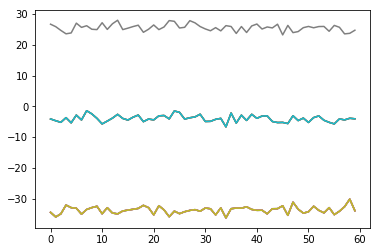

In [95]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(conf["num_epochs"]):
        sess.run([training_op], feed_dict={x : g_waves})
        if i%100 == 0:
            print(mse.eval(feed_dict={x : g_waves}))
            
    plt.figure()
    waves_out = out.eval(feed_dict={x : g_waves})
    for i in range(1000,1010):
        plt.plot(waves_out[i,:])

In [96]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())


In [ ]:
g_waves.shape

In [ ]:
len(g_waves)

In [ ]:
type(g_waves)